<a href="https://colab.research.google.com/github/cerasole/EnvironmentalRadioactivity/blob/main/Notebooks/SpectralFitHPGe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-Purity Germanium (HPGe)

In questo notebook analizziamo i dati presi in alcune acquisizioni di spettroscopia effettuate con un rivelatore a germanio.

Scaricheremo 1 file di testo contenente il tempo di acquisizione ove sta scritto "$MEAS_TIM" ed i valori dell'istogramma in ADC dei conteggi osservati.


In [1]:
!wget https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/HPGe/fondo_open.Spe

--2025-03-05 21:09:42--  https://raw.githubusercontent.com/cerasole/EnvironmentalRadioactivity/main/Data/HPGe/fondo_open.Spe
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164264 (160K) [text/plain]
Saving to: ‘fondo_open.Spe’

fondo_open.Spe      100%[===================>] 160.41K  --.-KB/s    in 0.03s   

2025-03-05 21:09:42 (4.98 MB/s) - ‘fondo_open.Spe’ saved [164264/164264]



In [2]:
!pip install iminuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 3.1 MB/s eta 0:00:00


In [3]:
# General libreries
import os, glob
import numpy as np
import matplotlib.pyplot as plt
plt.rc("font", size = 16)

# Fit
from iminuit import Minuit
from iminuit.cost import LeastSquares

files = glob.glob("*.Spe")
print("File a disposizione:", files)

class Acq ():

    def __init__(self, filename = None):
        self.filename = filename
        self.adc = None
        self.energy = None
        self.counts, self.counts_err = None, None
        self.time = None
        if filename is not None:
            self.read()
        return

    def read(self):
        self.counts = np.loadtxt(self.filename, unpack = True, skiprows = 12, max_rows = 8191)
        self.adc = np.arange(len(self.counts))
        self.bin_edges = np.arange(-0.5, len(self.counts)+0.5, 1)
        self.time = np.loadtxt(self.filename, skiprows = 9, max_rows = 1)[1]
        self.counts_err = np.sqrt(self.counts)
        self.rate = self.counts / self.time
        self.rate_err = self.counts_err / self.time
        return

File a disposizione: ['fondo_open.Spe']


In [4]:
data = Acq("fondo_open.Spe")

In [5]:
data.counts

array([0., 0., 0., ..., 8., 6., 4.])

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


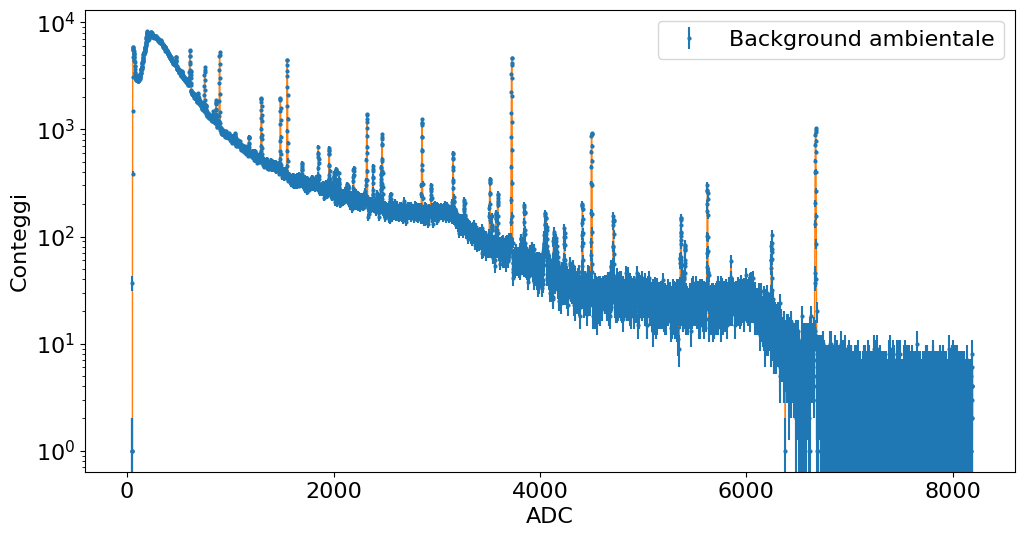

In [6]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(x = data.adc, y = data.counts, yerr = data.counts_err, ls = "None", marker = "o", ms = 2, label = "Background ambientale")
ax.stairs(data.counts, data.bin_edges)
ax.set_yscale("log")
ax.set_xlabel("ADC")
ax.set_ylabel("Conteggi")
ax.legend();

(5600.0, 5640.0)

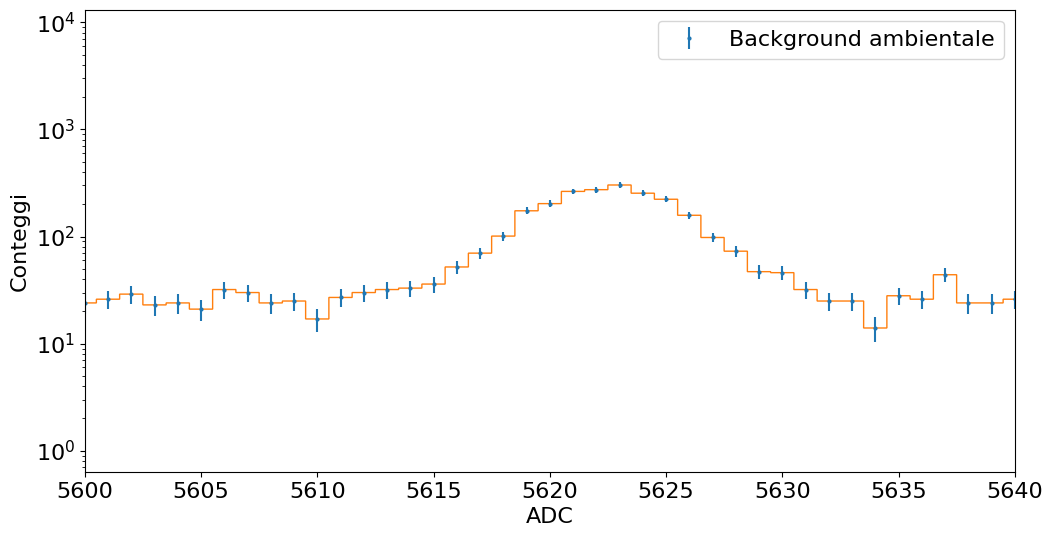

In [32]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(x = data.adc, y = data.counts, yerr = data.counts_err, ls = "None", marker = "o", ms = 2, label = "Background ambientale")
ax.stairs(data.counts, data.bin_edges)
ax.set_yscale("log")
ax.set_xlabel("ADC")
ax.set_ylabel("Conteggi")
ax.legend()
### Change the following line to change the zoom!
ax.set_xlim(5600, 5640)

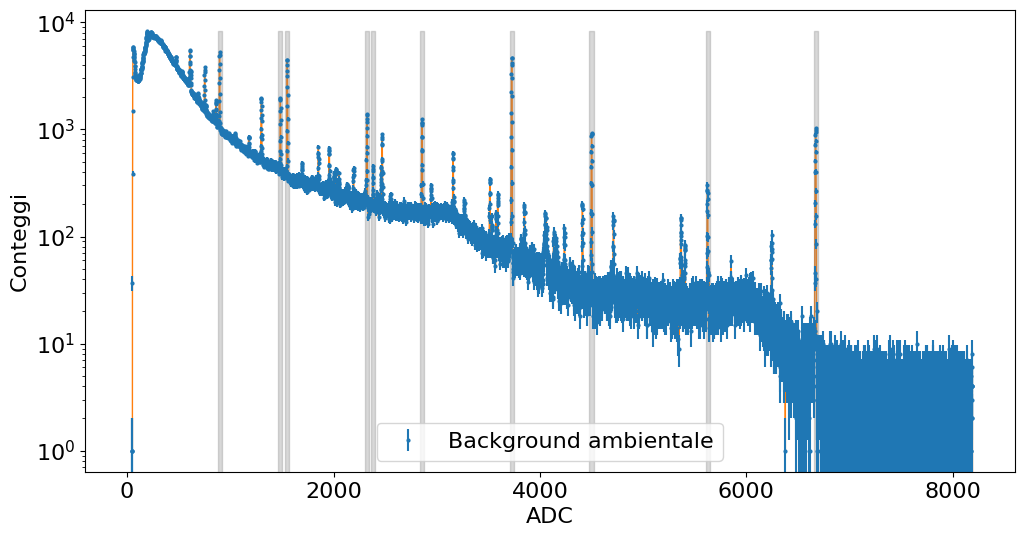

In [102]:
adc_peaks = np.array([897, 1484, 1552, 2323, 2382, 2858, 3727, 4500, 5624, 6671], dtype = np.float64)
energy_peaks = np.array([351.9, 583, 609.3, 911.1, 934.6, 1120.3, 1460, 1764.5, 2204.2, 2614.7])
adc_peaks_err = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype = np.float64)

fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(x = data.adc, y = data.counts, yerr = data.counts_err, ls = "None", marker = "o", ms = 2, label = "Background ambientale")
ax.stairs(data.counts, data.bin_edges)
ax.set_yscale("log")
ax.set_xlabel("ADC")
ax.set_ylabel("Conteggi")
ax.legend();

for i in range(len(adc_peaks)):
  ax.fill_between(
      y1 = np.ones(2) * np.max(data.counts),
      y2 = np.zeros(2),
      x = [adc_peaks[i] - 10*adc_peaks_err[i], adc_peaks[i] + 10*adc_peaks_err[i]],
          color = "gray", alpha = 0.3)

In [64]:
def gaus (x, A, mu, sigma):
  return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def pol1 (x, p0, p1):
  return p0 + p1*x

def gaus_pol1 (x, A, mu, sigma, p0, p1):
  return gaus (x, A, mu, sigma) + pol1 (x, p0, p1)

def fit_peak (data, energy, adc, adc_err):
  print (f" - Peak with energy {energy:.0f} keV")
  x1, x2 = adc - 20, adc + 20
  mask = (data.adc >= x1 ) * (data.adc <= x2)

  lsq = LeastSquares(x = data.adc[mask], y = data.counts[mask], yerror = data.counts_err[mask], model = gaus_pol1)
  m = Minuit(lsq, A = 1, mu = adc_peaks[i], sigma = adc_peaks_err[i], p0 = 1., p1 = -1.)
  m.limits["sigma"] = (0.1, 0.01*energy)
  m.limits["mu"] = (adc - adc_err, adc + adc_err)
  m.migrad()
  m.hesse()
  print (m)

  # Plot
  fig, axs = plt.subplots(2, 1, figsize = (6, 7), sharex = True, gridspec_kw={"height_ratios":[3., 1.]})
  fig.subplots_adjust(hspace = 0)

  ax = axs[0]
  ax.errorbar(x = data.adc[mask], y = data.counts[mask], xerr = np.diff(data.adc)[0]/2, yerr = data.counts_err[mask], ls = "None", marker = "o", ms = 4)
  ax.set_xlabel("ADC")
  ax.set_ylabel("Conteggi")
  ax.grid(which = "both")
  ax.set_yscale("log")
  ax.set_title(f"Peak with energy {energy_peaks[i]:.0f} keV")
  ax.set_ylim(bottom = max(0.2, 0.5*np.min(data.counts[mask] - data.counts_err[mask])), top = 1.3*np.max(data.counts[mask] - data.counts_err[mask]))

  x = np.linspace(x1, x2, 200)
  y = gaus_pol1(x, *m.values)
  y_gaus = gaus(x, *m.values[:3])
  y_pol1 = pol1(x, *m.values[3:])

  ax.plot(x, y, label = "Fit")
  ax.plot(x, y_gaus, label = "Gaussian")
  ax.plot(x, y_pol1, label = "Polynomial")
  ax.legend(fontsize = "small")

  ax = axs[1]
  residui =  (data.counts[mask] - gaus_pol1(data.adc[mask], *m.values)) / data.counts_err[mask]
  ax.errorbar(
      x = data.adc[mask],
      y = residui,
      xerr = np.diff(data.adc)[0]/2,
      yerr = 0,
      ls = "None",
      marker = "o",
      ms = 4,
  )
  ax.set_yticks([-3, 0, 3])
  ax.grid()
  ax.set_xlabel("ADC")
  ax.set_ylabel("Residuals")

  #fig2, ax2 = plt.subplots(figsize = (6, 5))
  #ax2.hist(residui, bins = int(len(residui)/6))
  #ax2.set_xlabel("Residuals")
  #ax2.set_ylabel("Counts")

  chi_reduced = m.fval / m.ndof
  print (f" Chi square / ndof of the fit is {m.fval:.2f} / {m.ndof} = {chi_reduced:.2f}")
  print (f" Corresponding ADC value is {m.values['mu']:.2f} +/- { m.errors['mu']:.2f}")
  return m.values["mu"], m.errors["mu"]

 - Peak with energy 352 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 31.31 (χ²/ndof = 0.9)      │              Nfcn = 371              │
│ EDM = 1.71e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

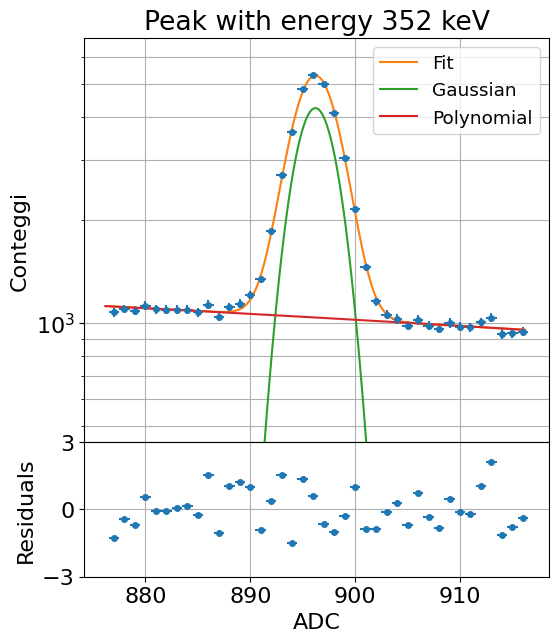

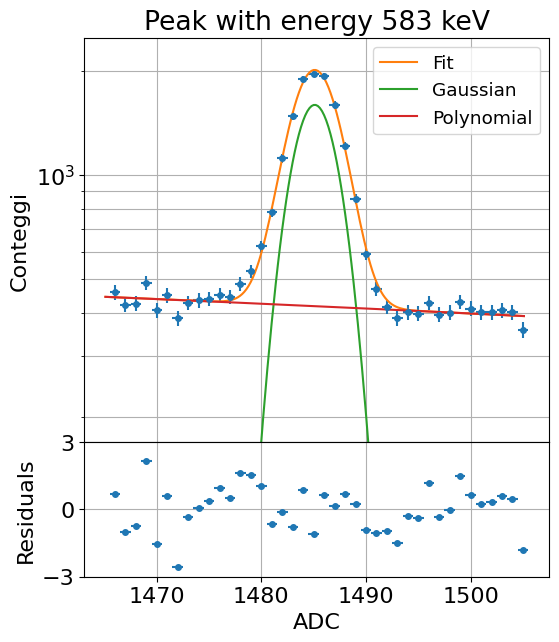

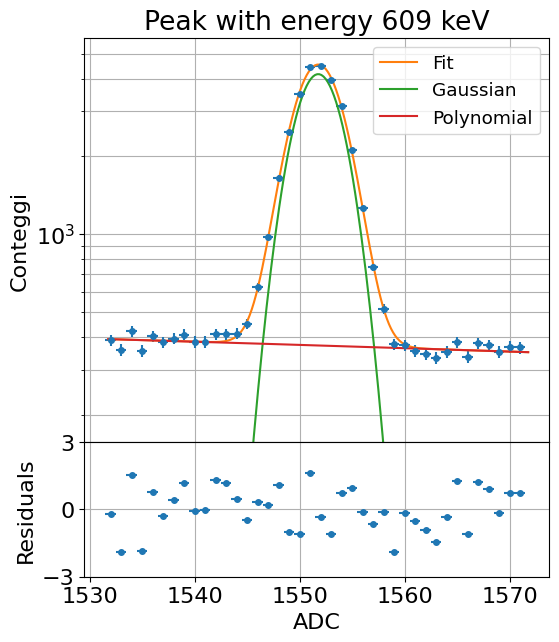

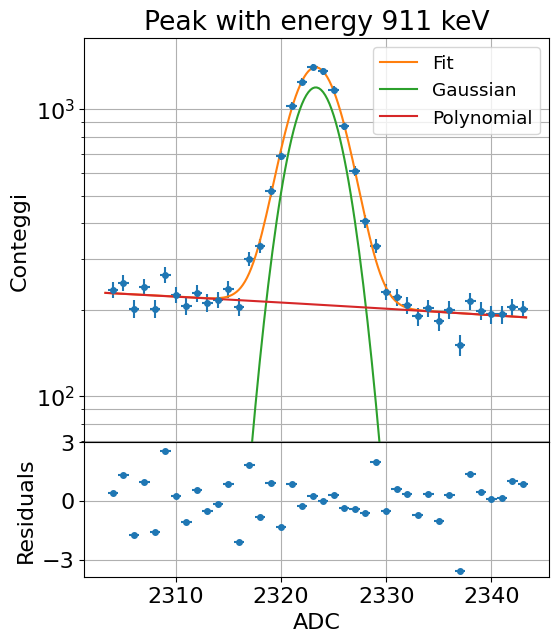

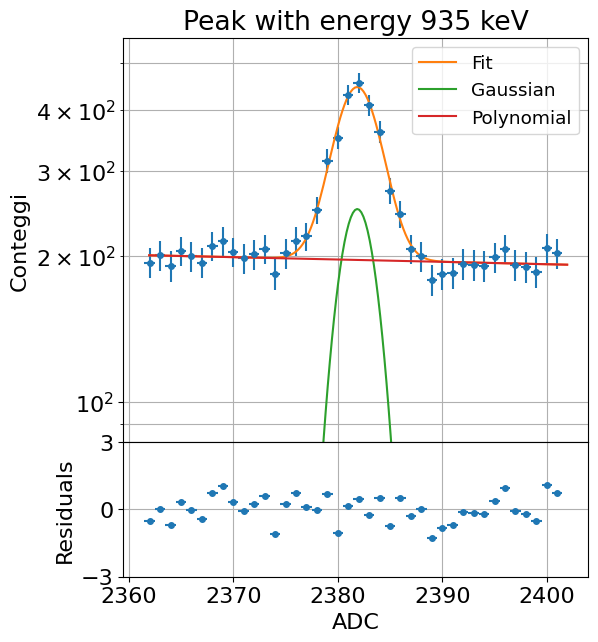

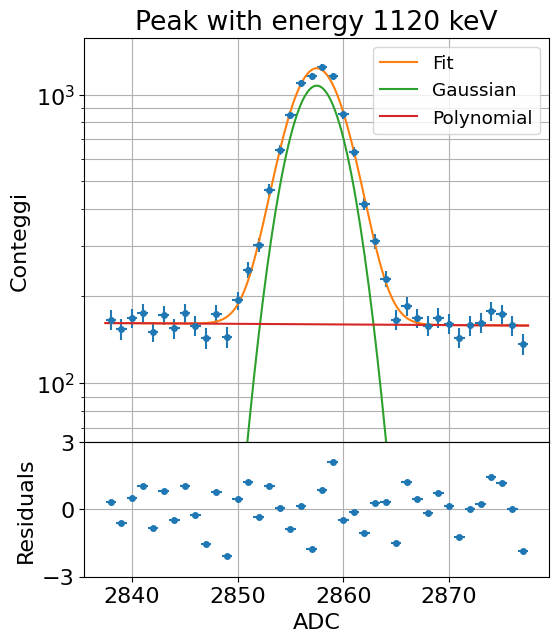

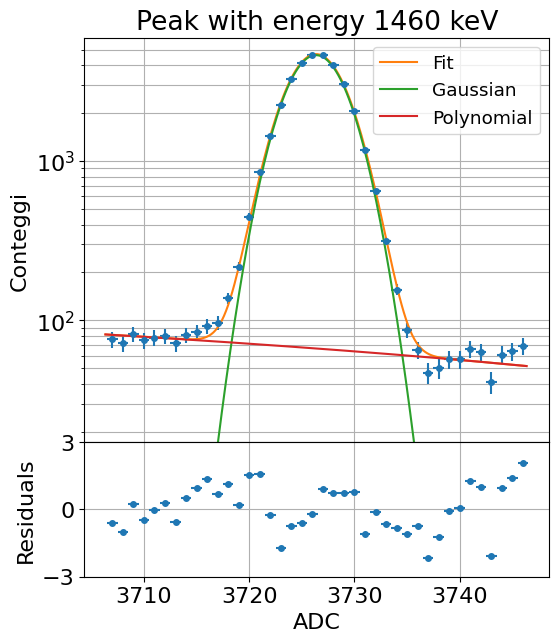

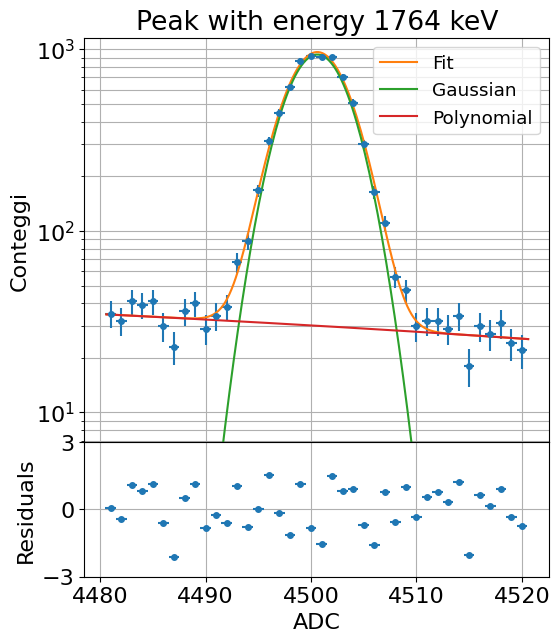

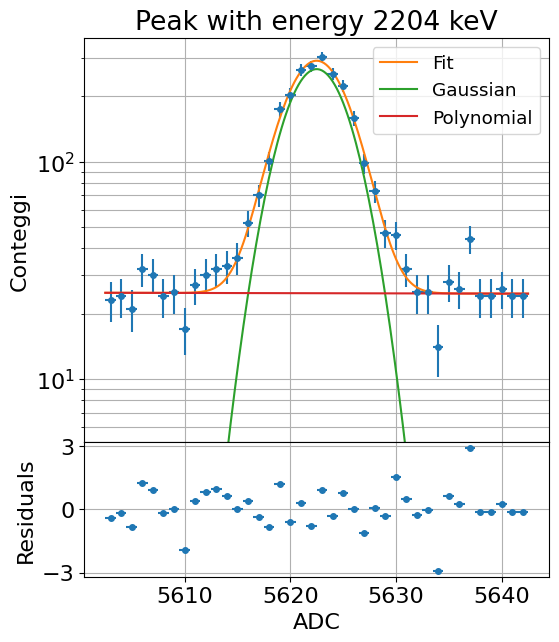

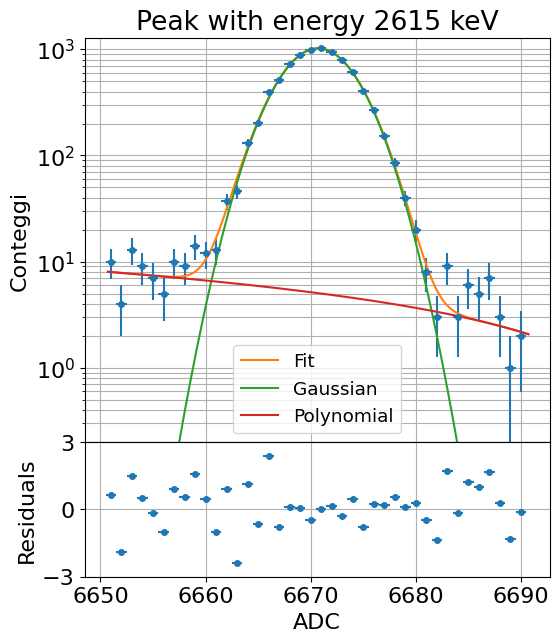

In [65]:
for i in range(len(adc_peaks)):
  adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 352 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.3 (χ²/ndof = 0.9)       │              Nfcn = 458              │
│ EDM = 6.09e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

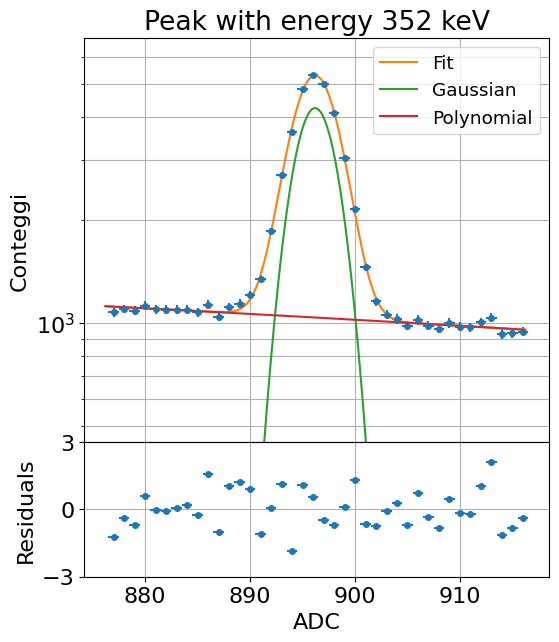

In [66]:
i = 0
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 583 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.48 (χ²/ndof = 1.1)      │              Nfcn = 344              │
│ EDM = 2.56e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

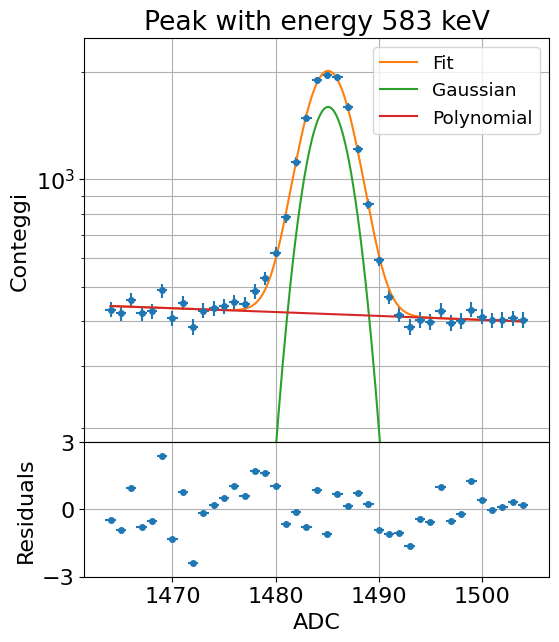

In [36]:
i = 1
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 609 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.25 (χ²/ndof = 1.1)      │              Nfcn = 399              │
│ EDM = 3.43e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

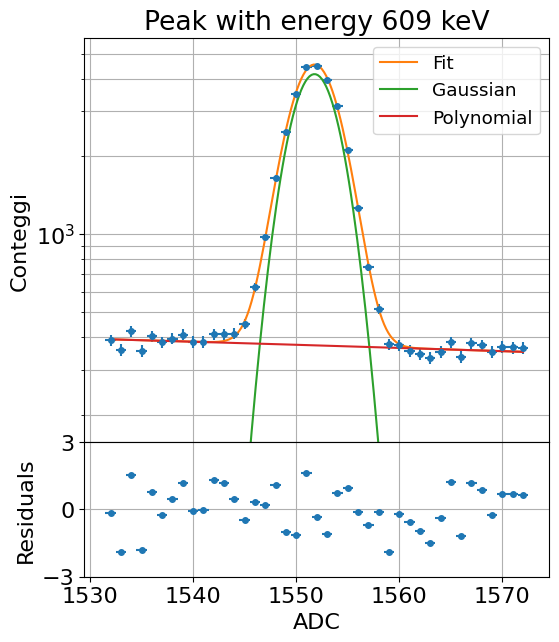

In [37]:
i = 2
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 911 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 53.86 (χ²/ndof = 1.5)      │              Nfcn = 575              │
│ EDM = 4.69e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

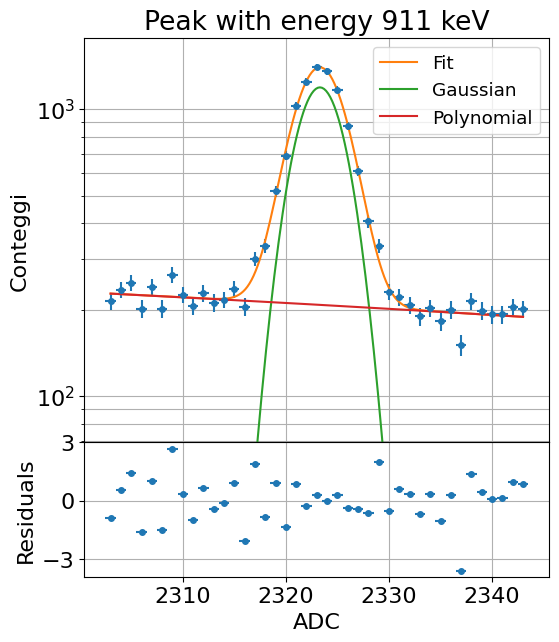

In [38]:
i = 3
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 935 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.79 (χ²/ndof = 0.4)      │              Nfcn = 440              │
│ EDM = 1.12e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

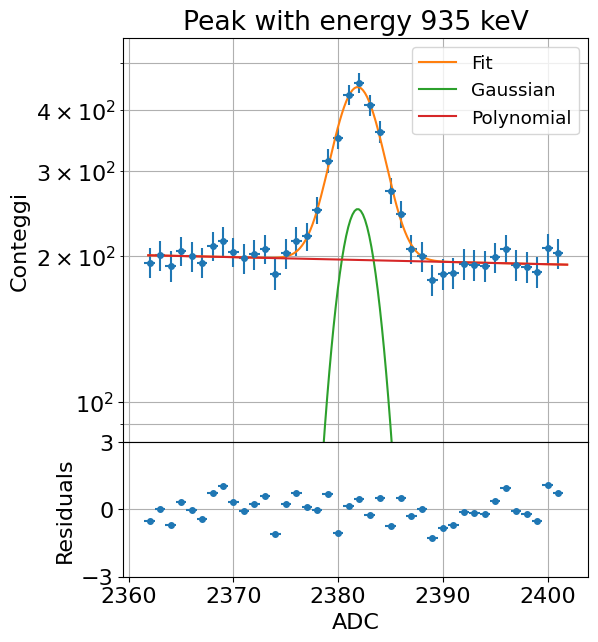

In [67]:
i = 4
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 1120 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.66 (χ²/ndof = 1.1)      │              Nfcn = 381              │
│ EDM = 6.99e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬─────────

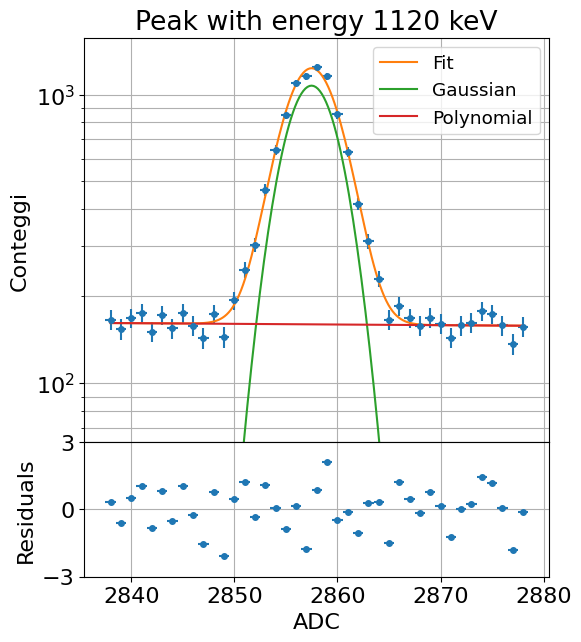

In [40]:
i = 5
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 1460 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.97 (χ²/ndof = 1.2)      │              Nfcn = 578              │
│ EDM = 2.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬─────────

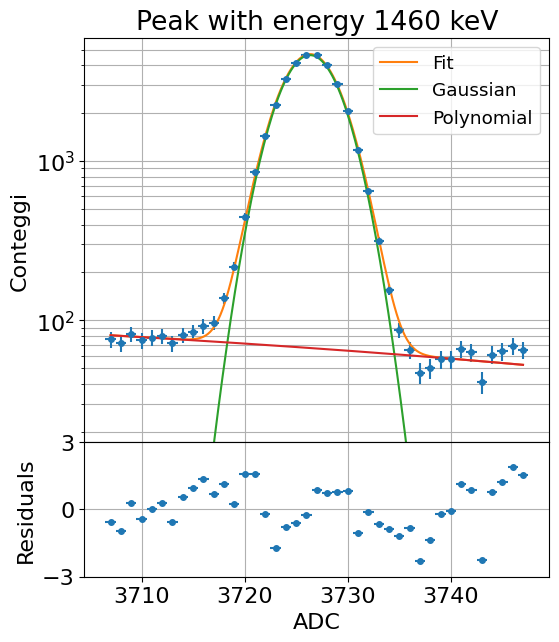

In [41]:
i = 6
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

 - Peak with energy 1764 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 37.98 (χ²/ndof = 1.1)      │              Nfcn = 616              │
│ EDM = 4.91e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬─────────

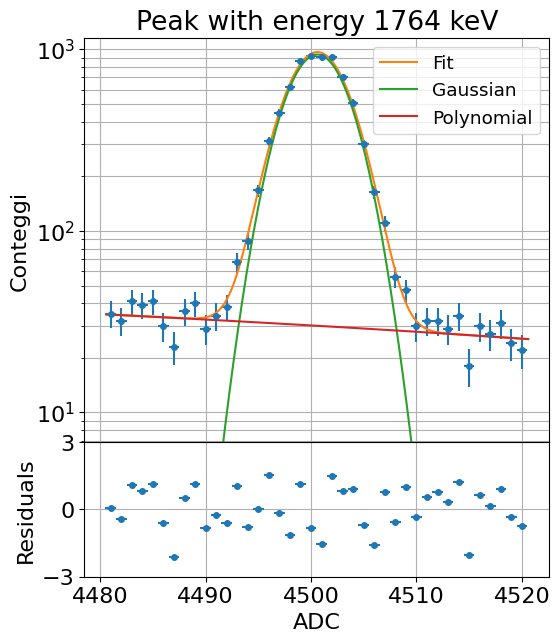

In [68]:
i = 7
adc_peaks[i], adc_peaks_err[i] = fit_peak(data, energy_peaks[i], adc_peaks[i], adc_peaks_err[i])

In [69]:
adc_peaks, adc_peaks_err

(array([ 896.19132662, 1485.09985887, 1551.77436519, 2323.30223446,
        2381.86575299, 2857.48826545, 3726.34467923, 4500.59555471,
        5622.49700551, 6670.70901427]),
 array([0.01901346, 0.05119935, 0.02611473, 0.05548453, 0.10153625,
        0.05912656, 0.02325169, 0.03540427, 0.11641068, 0.05191836]))

In [87]:
def linear(x, p0, p1):
  return p0 + p1*x

lsq = LeastSquares(x=energy_peaks, y=adc_peaks, yerror = 1, model = linear)
m = Minuit(lsq, p0 = 0, p1 = 1)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.782 (χ²/ndof = 1.2)      │              Nfcn = 54               │
│ EDM = 3.74e-15 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   -2.4    │    0.6    │            │            │         │         │       │
│ 1 │ p1   │  2.5522   │  0.0004   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │      0.417 -252.33e-6 │
│ p1 │ -252.33e-6   2.01e-07 │
└────┴───────────────────────┘

In [88]:
p0, p1 = m.values["p0"], m.values["p1"]
p0_err, p1_err = m.errors["p0"], m.errors["p1"]
print (p0, p0_err)
print (p1, p1_err)

-2.3602128823463318 0.6455657392315592
2.552213722447605 0.0004483383321990655


In [89]:
data.energy = (data.adc - p0) / p1

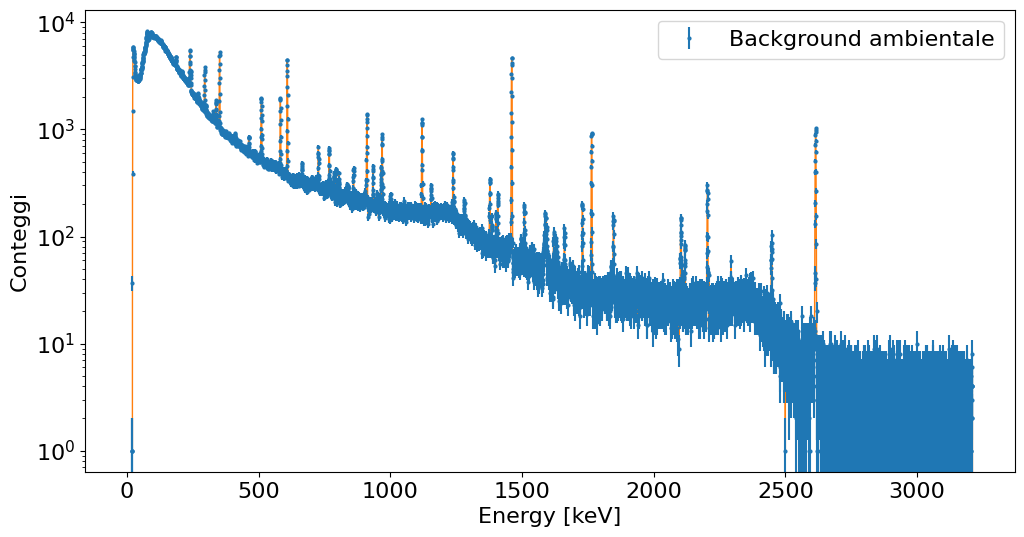

In [90]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.errorbar(x = data.energy, y = data.counts, yerr = data.counts_err, ls = "None", marker = "o", ms = 2, label = "Background ambientale")
ax.stairs(data.counts, (data.bin_edges-p0)/p1)
ax.set_yscale("log")
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Conteggi")
ax.legend();

In [97]:
def fit_energy_peak (data, energy):
  print (f" - Peak with energy {energy:.0f} keV")
  x1, x2 = energy - (20-p0)/p1, energy + (20-p0)/p1
  mask = (data.energy >= x1 ) * (data.energy <= x2)

  lsq = LeastSquares(x = data.energy[mask], y = data.counts[mask], yerror = data.counts_err[mask], model = gaus_pol1)
  m = Minuit(lsq, A = 1, mu = energy, sigma = 1, p0 = 1., p1 = -1.)
  m.limits["sigma"] = (0.1, 0.01*energy)
  m.limits["mu"] = (energy - 2, energy + 2)
  m.migrad()
  m.hesse()
  print (m)

  # Plot
  fig, axs = plt.subplots(2, 1, figsize = (6, 7), sharex = True, gridspec_kw={"height_ratios":[3., 1.]})
  fig.subplots_adjust(hspace = 0)

  ax = axs[0]
  ax.errorbar(x = data.energy[mask], y = data.counts[mask], xerr = np.diff(data.energy)[0]/2, yerr = data.counts_err[mask], ls = "None", marker = "o", ms = 4)
  ax.set_xlabel("Energy [keV]")
  ax.set_ylabel("Conteggi")
  ax.grid(which = "both")
  ax.set_yscale("log")
  ax.set_title(f"Peak with energy {energy_peaks[i]:.0f} keV")
  ax.set_ylim(bottom = max(0.2, 0.5*np.min(data.counts[mask] - data.counts_err[mask])), top = 1.3*np.max(data.counts[mask] - data.counts_err[mask]))

  x = np.linspace(x1, x2, 200)
  y = gaus_pol1(x, *m.values)
  y_gaus = gaus(x, *m.values[:3])
  y_pol1 = pol1(x, *m.values[3:])

  ax.plot(x, y, label = "Fit")
  ax.plot(x, y_gaus, label = "Gaussian")
  ax.plot(x, y_pol1, label = "Polynomial")
  ax.legend(fontsize = "small")

  ax = axs[1]
  residui =  (data.counts[mask] - gaus_pol1(data.energy[mask], *m.values)) / data.counts_err[mask]
  ax.errorbar(
      x = data.energy[mask],
      y = residui,
      xerr = np.diff(data.energy)[0]/2,
      yerr = 0,
      ls = "None",
      marker = "o",
      ms = 4,
  )
  ax.set_yticks([-3, 0, 3])
  ax.grid()
  ax.set_xlabel("Energy [keV]")
  ax.set_ylabel("Residuals")

  #fig2, ax2 = plt.subplots(figsize = (6, 5))
  #ax2.hist(residui, bins = int(len(residui)/6))
  #ax2.set_xlabel("Residuals")
  #ax2.set_ylabel("Counts")

  chi_reduced = m.fval / m.ndof
  print (f" Chi square / ndof of the fit is {m.fval:.2f} / {m.ndof} = {chi_reduced:.2f}")
  print (f" Corresponding ADC value is {m.values['mu']:.2f} +/- { m.errors['mu']:.2f}")
  return m.values["mu"], m.errors["mu"]

 - Peak with energy 352 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.14 (χ²/ndof = 0.9)      │              Nfcn = 513              │
│ EDM = 8.15e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

(352.0667175481182, 0.008129665282694987)

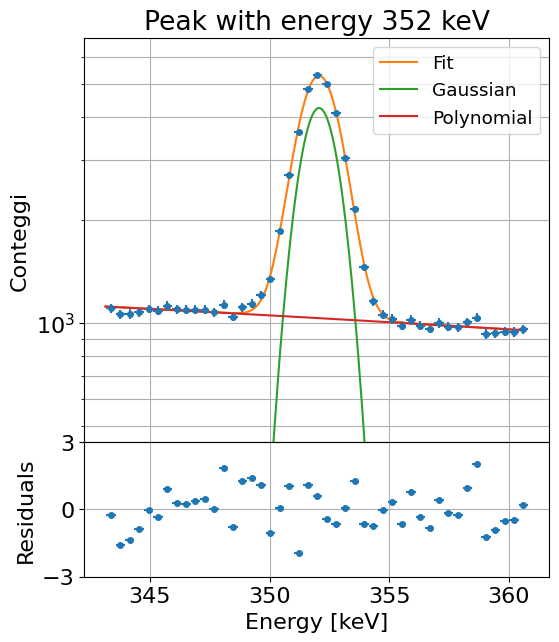

In [98]:
i = 0
fit_energy_peak(data, energy_peaks[i])

 - Peak with energy 352 keV
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.14 (χ²/ndof = 0.9)      │              Nfcn = 513              │
│ EDM = 8.15e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬──────────

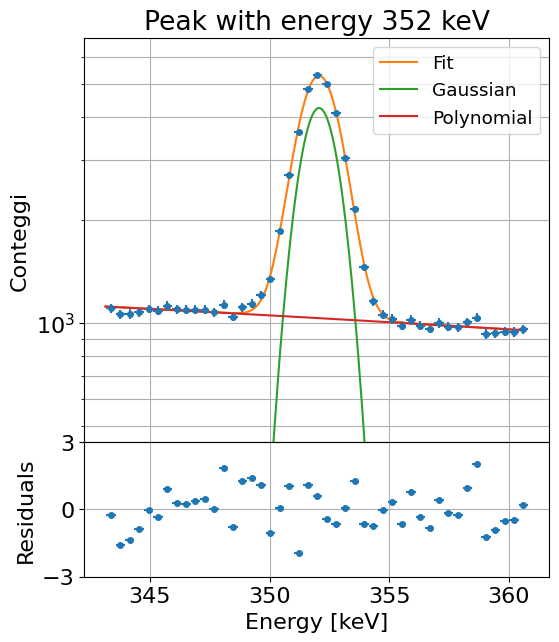

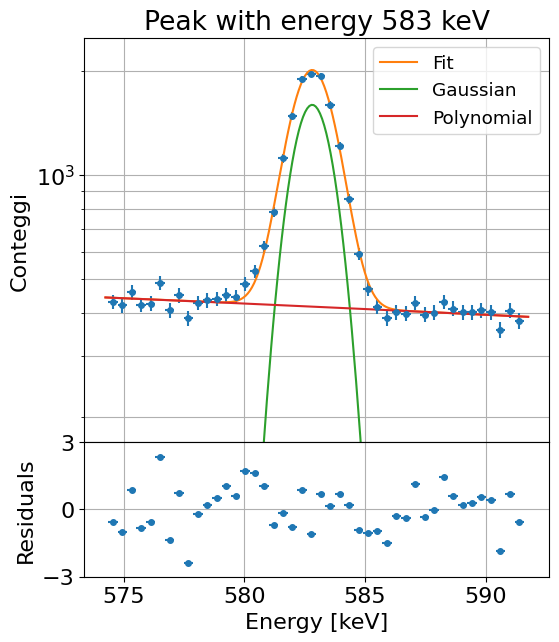

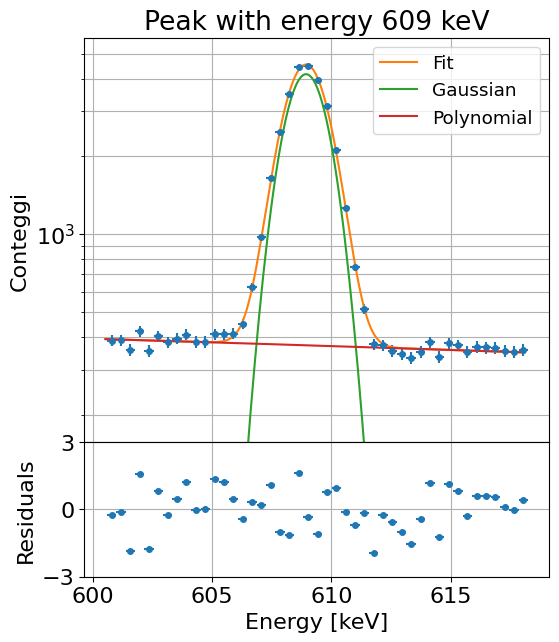

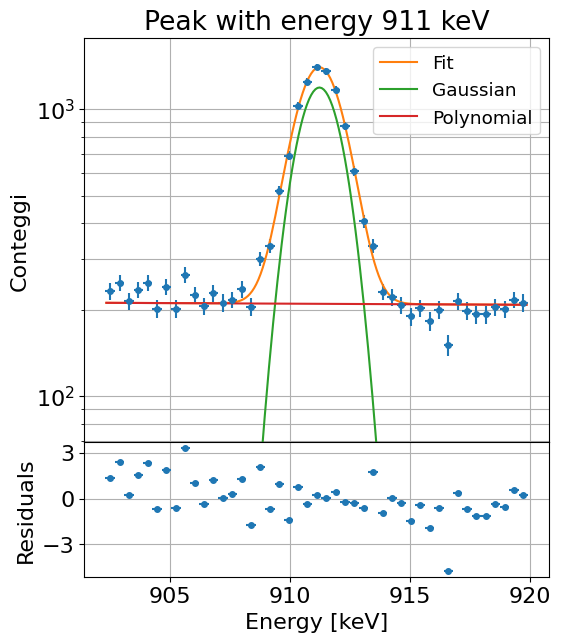

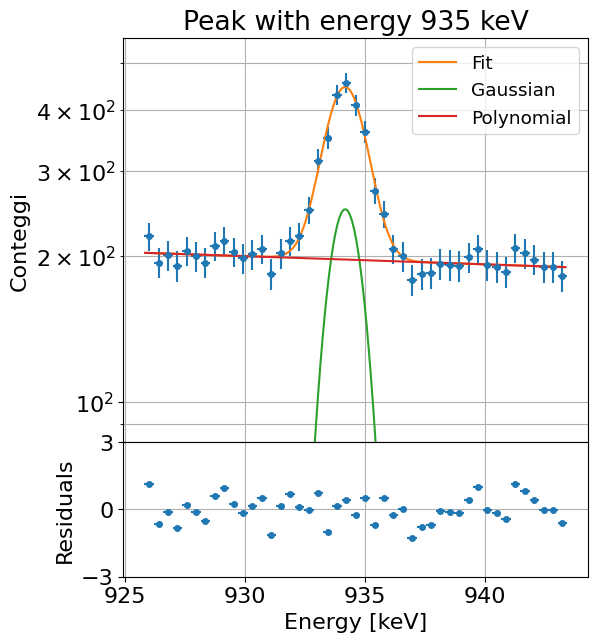

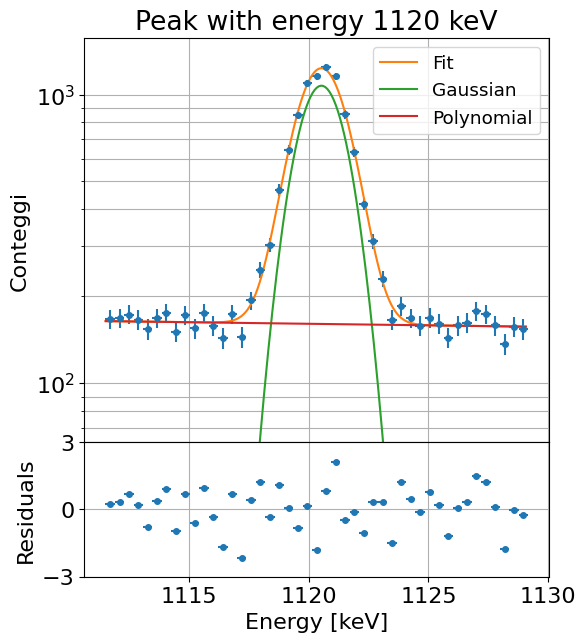

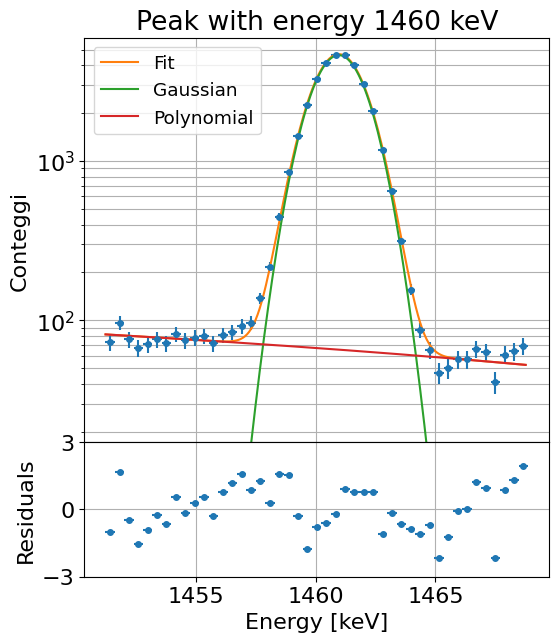

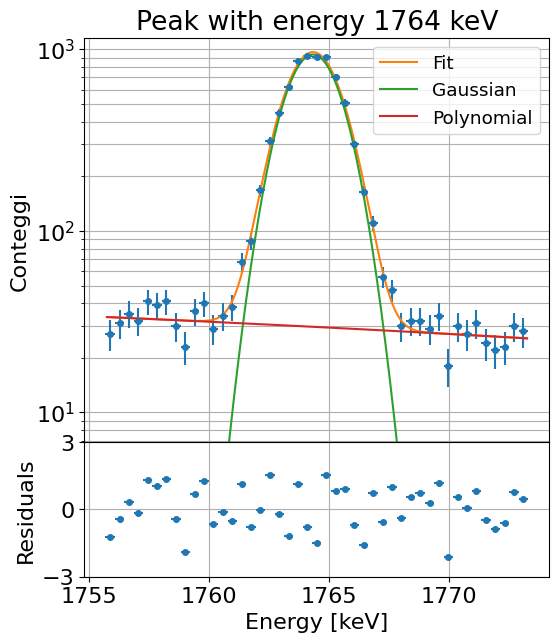

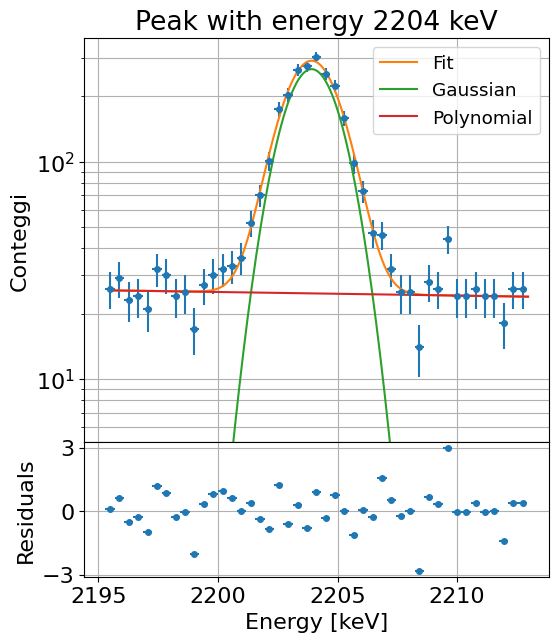

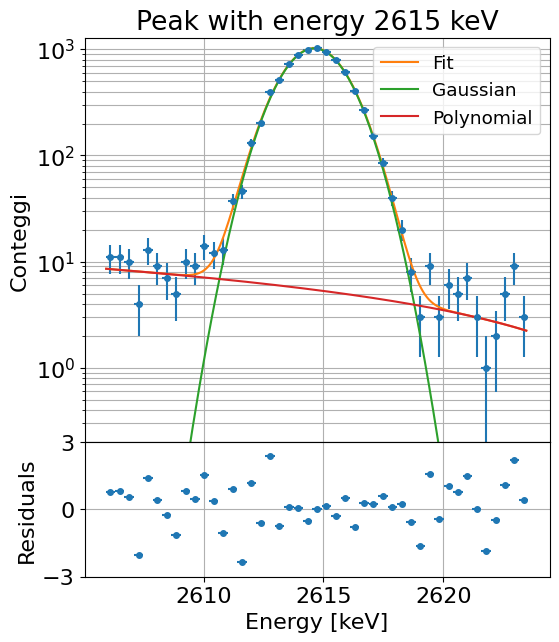

In [103]:
N = len(adc_peaks)
energy_peaks_postfit, energy_peaks_postfit_err = np.zeros(N), np.zeros(N)

for i in range(N):
    energy_peaks_postfit[i], energy_peaks_postfit_err[i] = fit_energy_peak(data, energy_peaks[i])

<ErrorbarContainer object of 3 artists>

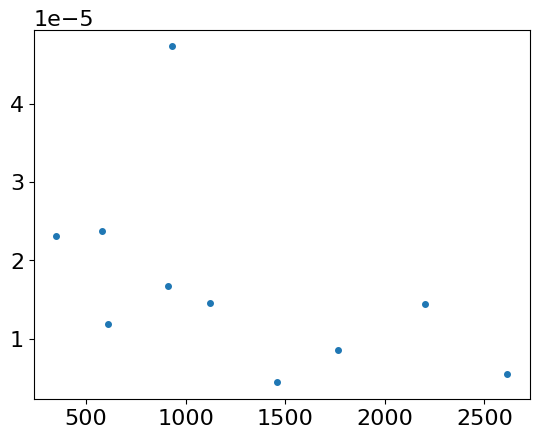

In [107]:
plt.errorbar(energy_peaks_postfit, energy_peaks_postfit_err/energy_peaks_postfit, ls = "None", marker = "o", ms = 4)